## Problem Statement

**Customer segmentation is defined as “the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately.” By using the correct attributes to define the customer segment, it allows companies to identify the right customers for targeted and relevant offers. Those who successfully define and maintain customer segmentation can derive a competitive advantage from the implementation by improving customer experience.**

## Introduction

### STP (Segmentation, Targeting, Positioning) Framework

1 - Segmentation helps you divide your potential or existing customers into different groups depending on their Demographic, Geographic, Psychographic, and Behavioral characteristics. Customers of each group share similar purchase behaviors and are likely to act similarly in different marketing activities. A generic marketing campaign like “one size fits all” doesn’t work best as a marketing strategy.

2 - Targeting: Once you know your customer segments, the next step is to select a subset of segments to focus on. It’s hard to make a product that satisfies everybody. That’s why it’s best to concentrate on the most important group of customers and make them happy. Later you can always increase your focus area and target more customers.

3 - Positioning: In this step, you map out the different attributes considered in the previous two steps and then position your product. This helps you identify what products and offerings you want to offer that will best satisfy your customer’s needs. The positioning also guides you on how those products should be presented to the customers and through what channel. There is another framework used in this process, called Marketing Mix.

## Necessary libraries

In [189]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

sns.set()

## Data Exploration: Get to know the dataset

### Data importation

We are going to use a pre-processed FMCG (Fast Moving Consumer Goods) dataset, which contains customer details of 2000 individuals as well as their purchase activities.

In [190]:
# If you want you can import kaggle datasets directly from kaggle into your notebook

# import kaggle
# !kaggle datasets download -d carrie1/ecommerce-data --unzip

In [191]:
df_customers=pd.read_csv('customers.csv',index_col=0)
df_customers.head(5)

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [192]:
df_customers.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


### Pairwise correlation of variables

In [193]:
df_customers.corr()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Sex,1.000000,0.566511,-0.182885,0.244838,-0.195146,-0.202491,-0.300803
Marital status,0.566511,1.000000,-0.213178,0.374017,-0.073528,-0.029490,-0.097041
Age,-0.182885,-0.213178,1.000000,0.654605,0.340610,0.108388,0.119751
Education,0.244838,0.374017,0.654605,1.000000,0.233459,0.064524,0.034732
Income,-0.195146,-0.073528,0.340610,0.233459,1.000000,0.680357,0.490881
Occupation,-0.202491,-0.029490,0.108388,0.064524,0.680357,1.000000,0.571795
Settlement size,-0.300803,-0.097041,0.119751,0.034732,0.490881,0.571795,1.000000


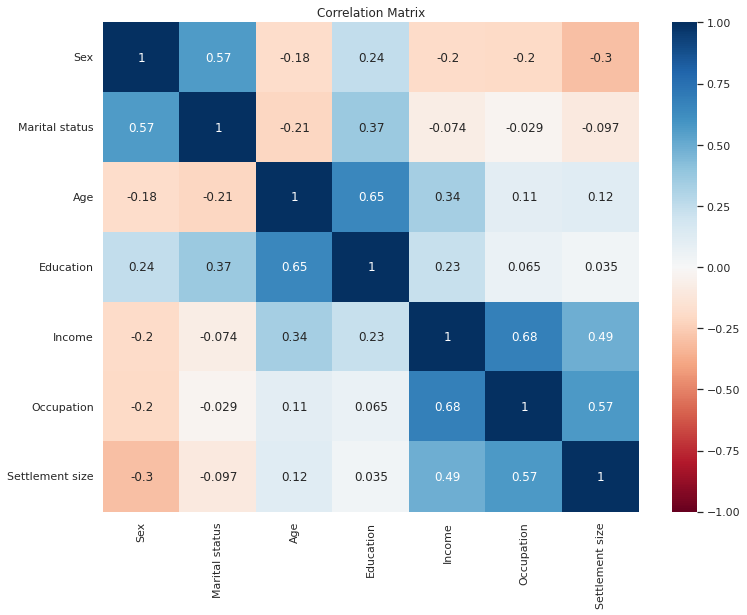

In [194]:
plt.figure(figsize=(12, 9))
s = sns.heatmap(df_customers.corr(),
                annot=True,
                cmap='RdBu',
                vmin=-1,
                vmax=1)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.title('Correlation Matrix')
plt.show()

With this heat map, we see that there is a strong positive correlation between age and education or between occupation and income. 

These inter-variable correlations will be important in the feature selection of the segmentation process.

### Data Preprocessing

In [195]:
scaler = StandardScaler()
customers_std=scaler.fit_transform(df_customers)

### Hierarchical Clustering

We’ll use the dendrogram and linkage from Scipy’s hierarchy module for clustering the dataset.
A dendrogram is a tree-like hierarchical representation of data points. It is most commonly used to represent hierarchical clustering. Linkage, on the other hand, is the function that helps us to implement the clustering. Here we need to specify the method to compute the distance between two clusters, and at completion, the linkage function returns the hierarchical cluster in a linkage matrix.

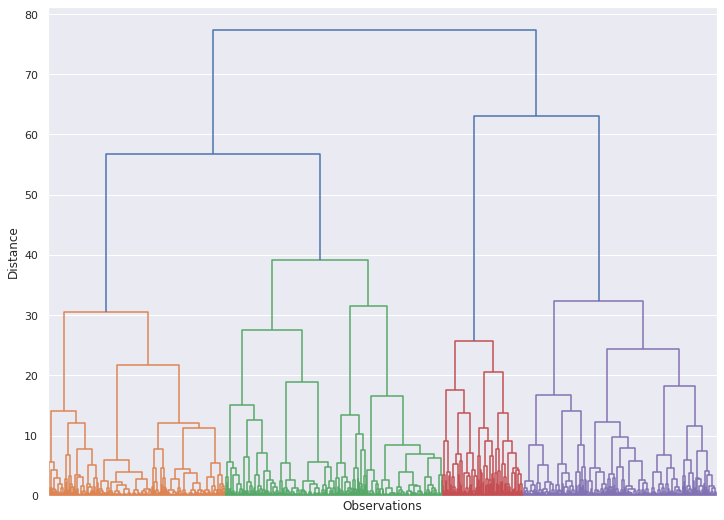

In [196]:
h_cluster = linkage(customers_std, method='ward')

plt.figure(figsize=(12, 9))
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(h_cluster,
           show_leaf_counts=False,
           no_labels=True)
plt.show()

At the bottom of the plot on the x-axis, we have the observations. These are the 2000 individual customer data points. On the y-axis, we see the distance between points or clusters represented by the vertical lines. The smaller the distance between points, the further down in the tree they’ll be grouped together.

### Identify the number of clusters manually

The process is to slice through the biggest vertical line that is not intercepted by any extended horizontal line. And after the slice, the number of clusters under the slicing line would be the best number of clusters.
In the following diagram, we see two candidate vertical lines, and between them, “candidate 2” is the taller. So we would cut through that line which would produce 4 clusters underneath.

![Picture title](image-20220922-153840.png)

Hierarchical clustering is very simple to implement and it returns the optimal number of clusters in the data, but unfortunately, because of its slowness, it is not used in real life. Instead, we often use K-means clustering. In our next post, we’ll see how to implement K-means clustering and we’ll try to optimize it with PCA.

### k-means clustering

Hierarchical clustering is great for small datasets, but as the dataset size grows, the computational demands grows rapidly. Because of this, hierarchical clustering isn’t practical

K-means clustering can segment an unlabeled dataset into a pre-determined number of groups.

![Picture title](image-20220924-153624.png)

### The elbow method

we use the ‘elbow method’ to identify the value of ‘k’ (number of clusters).
This method essentially is a brute-force approach, where we calculate the sum of the squared distance between each member of the cluster and its centroid for some value of ‘k’ (e.g. 2–10) and plot ‘k’ against the squared distance. As the number of clusters increases, the average distortion will decrease, meaning the cluster centroids move closer to each data point. In the plot, this will produce an elbow-like structure hence the name ‘elbow method’. We’ll choose the value of ‘k’ at which the distance decreases abruptly

In [197]:
results = {}

for i in range (1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(customers_std)
    results[i] = kmeans.inertia_

In [198]:
results

{1: 14000.0,
 2: 10514.558847734443,
 3: 8630.913216898227,
 4: 7169.87082246584,
 5: 6403.134167928612,
 6: 5830.9563029611545,
 7: 5378.854705323012,
 8: 5005.134609766622,
 9: 4724.527779695852,
 10: 4295.656622405144}

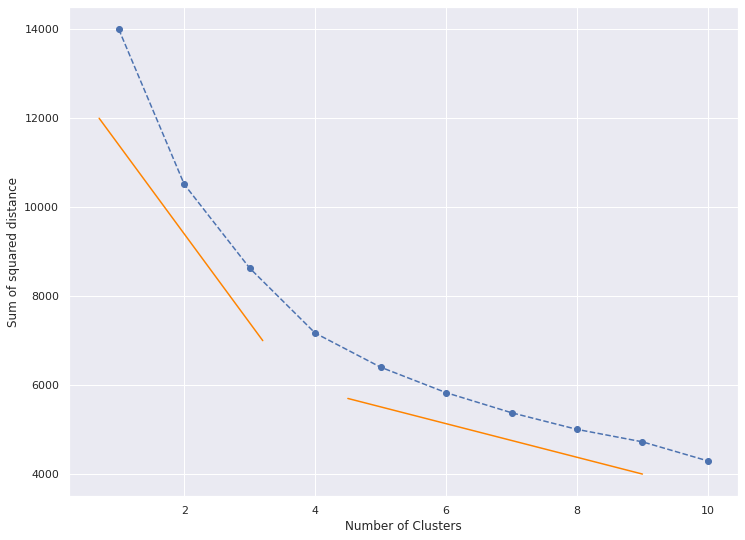

In [199]:
plt.figure(figsize=(12, 9))
plt.plot(np.array(list(results.keys())).astype(float), np.array(list(results.values())).astype(float), marker='o', linestyle='--')
plt.plot([0.7, 3.2], [12000, 7000], color='#FF8400')
plt.plot([4.5, 9], [5700, 4000], color='#FF8400')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distance')
plt.show()

As we can see in the above graph, the line declines stiffly until we reach the number of cluster 4, and declines more smoothly after that. Meaning that our elbow is at 4 and that is the optimal number of clusters for us. This also aligns with the output of hierarchical clustering that we did.

Now let’s perform k-means clustering with 4 clusters, and include the segment number with our data frame.

In [200]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(customers_std)

KMeans(n_clusters=4, random_state=42)

In [201]:
df_customers_kmeans = df_customers.copy()
df_customers_kmeans['Segment'] = kmeans.labels_  # It will contain the predicted clusters for each observation in our data set
df_customers_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment
ID,,,,,,,,
100000001,0,0,67,2,124670,1,2,0
100000002,1,1,22,1,150773,1,2,2
100000003,0,0,49,1,89210,0,0,1
100000004,0,0,45,1,171565,1,1,3
100000005,0,0,53,1,149031,1,1,3
...,...,...,...,...,...,...,...,...
100001996,1,0,47,1,123525,0,0,1
100001997,1,1,27,1,117744,1,0,2
100001998,0,0,31,0,86400,0,0,1


we’ve segmented our customers into 4 groups. Now let’s try to understand the characteristics of each group. At first, let's see the mean value of each feature by clusters:

In [202]:
df_customers_analysis = df_customers_kmeans.groupby('Segment').mean().round(3)
df_customers_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment,,,,,,,
0,0.502,0.692,55.703,2.129,158338.422,1.129,1.110
1,0.353,0.019,35.578,0.747,97859.853,0.329,0.043
2,0.854,0.997,28.963,1.068,105759.119,0.634,0.423
3,0.030,0.174,35.635,0.733,141218.249,1.272,1.523


![Picture title](image-20220924-155210.png)

In [203]:
df_customers_analysis['Count'] = df_customers_kmeans[['Segment', 'Sex']].groupby('Segment').count()
df_customers_analysis['%'] = df_customers_analysis['Count'] / df_customers_analysis['Count'].sum()
df_customers_analysis.rename(index={
    0: 'well-off',
    1: 'fewer-opportunities',
    2: 'standard',
    3: 'career-focused'
}, inplace=True)

df_customers_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Count,%
Segment,,,,,,,,,
well-off,0.502,0.692,55.703,2.129,158338.422,1.129,1.110,263,0.1315
fewer-opportunities,0.353,0.019,35.578,0.747,97859.853,0.329,0.043,462,0.2310
standard,0.854,0.997,28.963,1.068,105759.119,0.634,0.423,705,0.3525
career-focused,0.030,0.174,35.635,0.733,141218.249,1.272,1.523,570,0.2850


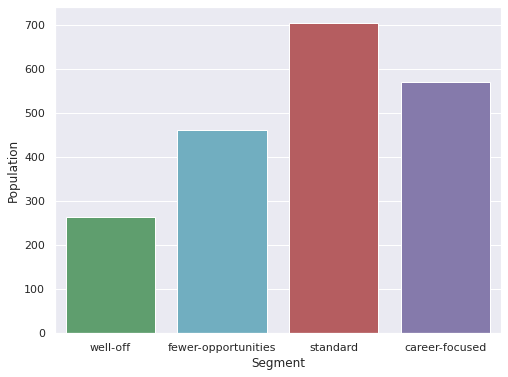

In [204]:
plt.figure(figsize=(8, 6))
s = sns.barplot(data=df_customers_analysis, x=df_customers_analysis.index, y='Count', palette=['g','c','r','m'])
plt.xlabel('Segment')
plt.ylabel('Population')
plt.show()

### Visualize our customer segments

- Age vs Income:

In [205]:
df_customers_kmeans['Segment'] = df_customers_kmeans['Segment'].map({
    0: 'well-off',
    1: 'fewer-opportunities',
    2: 'standard',
    3: 'career-focused'
})
df_customers_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment
ID,,,,,,,,
100000001,0,0,67,2,124670,1,2,well-off
100000002,1,1,22,1,150773,1,2,standard
100000003,0,0,49,1,89210,0,0,fewer-opportunities
100000004,0,0,45,1,171565,1,1,career-focused
100000005,0,0,53,1,149031,1,1,career-focused
...,...,...,...,...,...,...,...,...
100001996,1,0,47,1,123525,0,0,fewer-opportunities
100001997,1,1,27,1,117744,1,0,standard
100001998,0,0,31,0,86400,0,0,fewer-opportunities


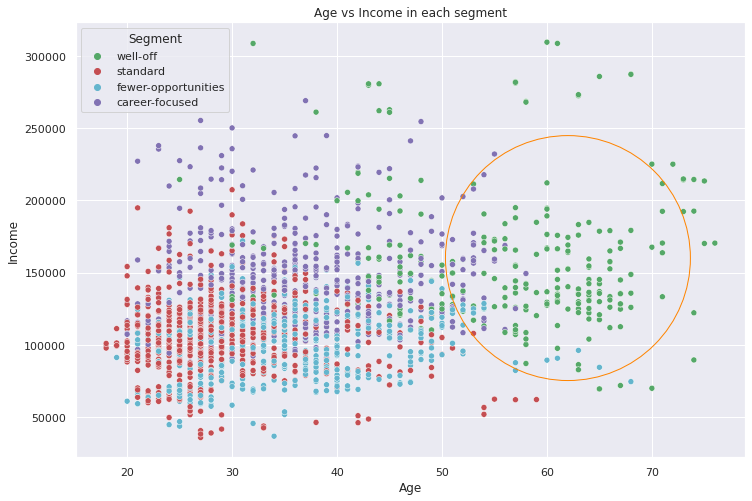

In [206]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=df_customers_kmeans['Age'],
    y=df_customers_kmeans['Income'],
    hue=df_customers_kmeans['Segment'],
    palette=['g','r','c','m']
)
plt.scatter(62, 160000 , s=60000, facecolors='none', edgecolors='#FF8400' ) 
plt.title('Age vs Income in each segment')
plt.show()

- Education vs Income:

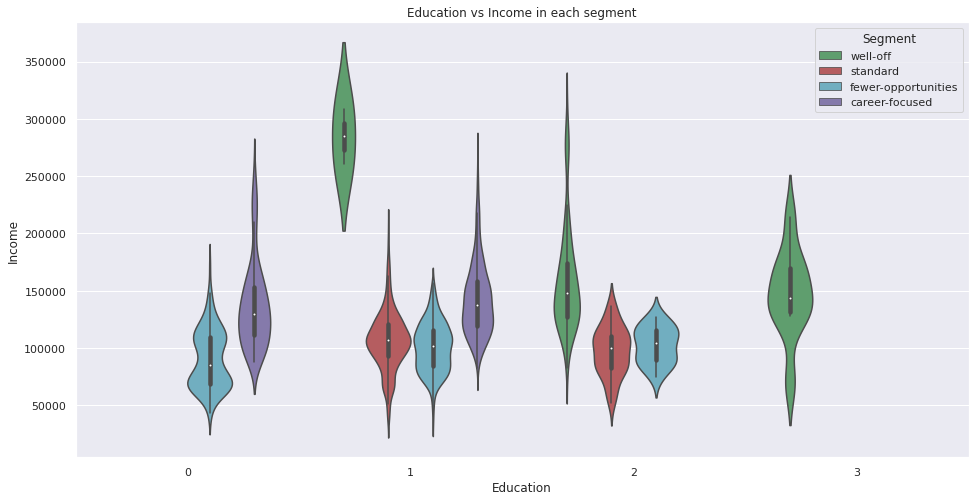

In [207]:
plt.figure(figsize=(16, 8))
sns.violinplot(
    x=df_customers_kmeans['Education'],
    y=df_customers_kmeans['Income'],
    hue=df_customers_kmeans['Segment'],
    palette=['g','r','c','m']
)
plt.title('Education vs Income in each segment')
plt.show()

### Conclusion

We observe in the ‘age vs income’ scatter plot that higher age customers with higher income (well-off) are separated, but the other three segments are not that distinguishable.

In the second observation, ‘education vs income’ violin plot, we see that customers with no educational records have lower income, and those who graduated have higher income. But other segments are not that separable.

Following these observations, we can conclude that k-means did a decent job separating the data into clusters. However, the outcome is not that satisfactory.

### Principal Component Analysis (PCA)

When multiple features in a dataset are highly correlated it can skew the outcome of the model because of redundant information. That’s what happened with our k-means model. It is called a multicollinearity problem. We can solve this by reducing dimensionality.

The correlation matrix in the first article showed that Age and Education are correlated, and Income and Occupation are also correlated. We will tackle this using Principle Component Analysis (PCA), a dimensionality reduction method.

### Identifying principal components

In [208]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(customers_std)

pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

The property “explained_variance_ratio_” of the pca object contains seven components that explain 100% of the variability of our dataset. The first component explains about 36% of the variability, 2nd and 3rd component explain 26% and 19% of variability, respectively.

Text(0, 0.5, 'Cumulative Explained Variance')

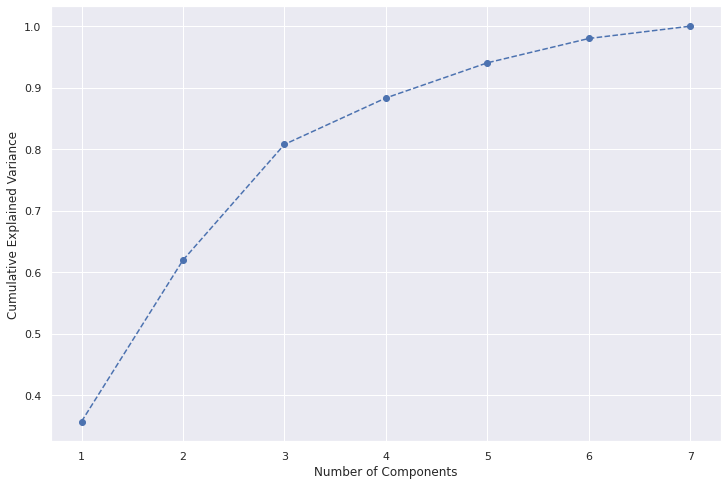

In [209]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, 8), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

The rule of thumb is to pick the number of components that retain 70–80% of the variability. If we select three top components, they will already hold more than 80% variability, and if we pick four components, they will retain almost 90% variability. Let’s pick three components and fit our pca model.
Then we create a dataframe with the three principle components while using the columns from our original dataset. Notice, that all values in the dataframe are between negative one and one as they are essentially correlations.

In [210]:
pca = PCA(n_components=3)
pca.fit(customers_std)

df_pca_components = pd.DataFrame(
    data=pca.components_.round(4),
    columns=df_customers.columns.values,
    index=['component 1', 'component 2', 'component 3'])

df_pca_components

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
component 1,-0.3147,-0.1917,0.3261,0.1568,0.5245,0.4921,0.4648
component 2,0.4580,0.5126,0.3122,0.6398,0.1247,0.0147,-0.0696
component 3,-0.2930,-0.4420,0.6095,0.2756,-0.1657,-0.3955,-0.2957


### The new correlation matrix

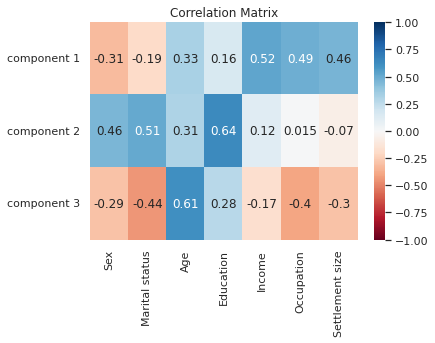

In [211]:
s = sns.heatmap(
    df_pca_components,
    vmin=-1,
    vmax=1,
    cmap='RdBu',
    annot=True
)
plt.title('Correlation Matrix')
plt.show()

Component one has a positive correlation with age, income, occupation, and settlement size. These features are related to the career of a person.

On the other hand, sex, marital status, and education are the most prominent determinant for the second component. We can also see in this component all career-related features are uncorrelated. Therefore, this component doesn’t refer to an individual’s profession but rather education and lifestyle.

For the third component, we observe that age, marital status, and occupation are the most prominent determinants. Marital status and occupation weigh negatively but are still important.

### K-Means Clustering with PCA

In [212]:
pca_scores = pca.transform(customers_std)

results = {}

for i in range(1, 11):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(pca_scores)   # pca_scores are standarzied by default
    results[i] = kmeans_pca.inertia_

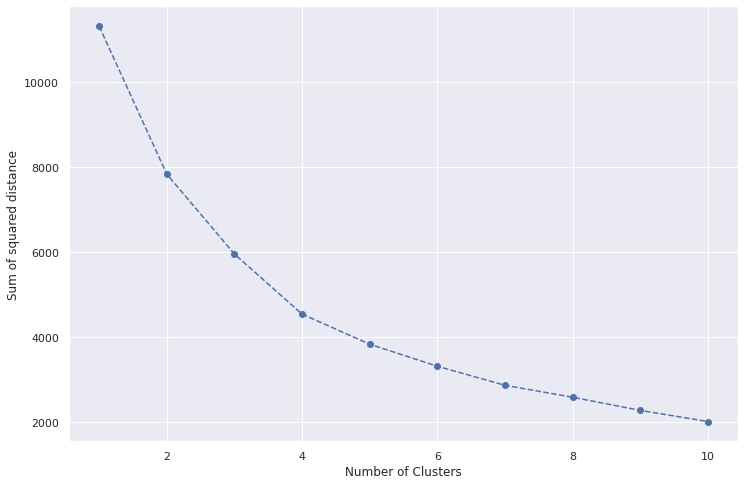

In [213]:
plt.figure(figsize=(12, 8))
plt.plot(np.array(list(results.keys())).astype(float), np.array(list(results.values())).astype(float), marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distance')
plt.show()

In [214]:
kmeans_pca = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_pca.fit(pca_scores)

KMeans(n_clusters=4, random_state=42)

In [215]:
df_segm_pca = pd.concat([df_customers.reset_index(drop=True), pd.DataFrame(pca_scores)], axis=1)
df_segm_pca.columns.values[-3:] = ['component 1', 'component 2', 'component 3']
df_segm_pca['K-means PCA'] = kmeans_pca.labels_

df_segm_pca

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,component 1,component 2,component 3,K-means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,3
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,2
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,1
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,1
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,2
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,0
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,2
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,0


### Analyze segmentation results

we’ve established that component one represents career, component two represents education & lifestyle and component three represents life or work experience

In [216]:
df_segm_pca_analysis = df_segm_pca.groupby(['K-means PCA']).mean().round(4)
df_segm_pca_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,component 1,component 2,component 3
K-means PCA,,,,,,,,,,
0,0.9003,0.9653,28.8786,1.0607,107551.5000,0.6777,0.4408,-1.1070,0.7038,-0.7814
1,0.0274,0.1681,35.7376,0.7341,141525.8268,1.2676,1.4803,1.3727,-1.0462,-0.2480
2,0.3065,0.0957,35.3130,0.7609,93692.5674,0.2522,0.0391,-1.0464,-0.9030,1.0036
3,0.5057,0.6906,55.6792,2.1283,158019.1019,1.1208,1.1019,1.6873,2.0312,0.8440


❏ Segment 0: low career and experience values with high education and lifestyle values.
Label: Standard
❏ Segment 1: high career but low education, lifestyle, and experience
Label: Career-focused
❏ Segment 2: low career, education and lifestyle, but high life experience
Label: Fewer opportunities
❏ Segment 3: high career, education and lifestyle as well as high life experience
Label: Well-off

In [217]:
df_segm_pca_analysis['Count'] = df_segm_pca[['K-means PCA', 'Sex']].groupby(['K-means PCA']).count()
df_segm_pca_analysis['%'] = df_segm_pca_analysis['Count'] / df_segm_pca_analysis['Count'].sum()
df_segm_pca_analysis.rename(index={
    0: 'standard',
    1: 'career-focused',
    2: 'fewer-opportunities',
    3: 'well-off'
}, inplace=True)

df_segm_pca_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,component 1,component 2,component 3,Count,%
K-means PCA,,,,,,,,,,,,
standard,0.9003,0.9653,28.8786,1.0607,107551.5000,0.6777,0.4408,-1.1070,0.7038,-0.7814,692,0.3460
career-focused,0.0274,0.1681,35.7376,0.7341,141525.8268,1.2676,1.4803,1.3727,-1.0462,-0.2480,583,0.2915
fewer-opportunities,0.3065,0.0957,35.3130,0.7609,93692.5674,0.2522,0.0391,-1.0464,-0.9030,1.0036,460,0.2300
well-off,0.5057,0.6906,55.6792,2.1283,158019.1019,1.1208,1.1019,1.6873,2.0312,0.8440,265,0.1325


- Customers per segment:

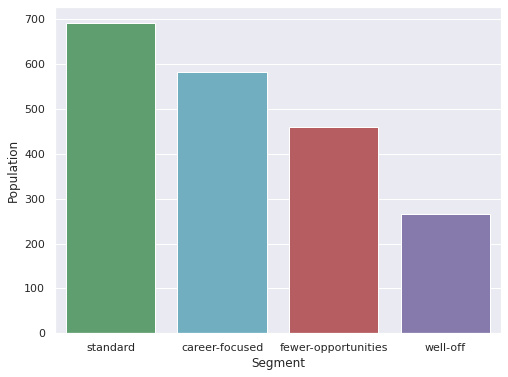

In [218]:
plt.figure(figsize=(8, 6))
s = sns.barplot(data=df_segm_pca_analysis, x=df_segm_pca_analysis.index, y='Count', palette=['g','c','r','m'])
plt.xlabel('Segment')
plt.ylabel('Population')
plt.show()

Let’s visualize the segments with respect to the first two components.

In [219]:
df_segm_pca['Segment'] = df_segm_pca['K-means PCA'].map({
    0: 'standard',
    1: 'career-focused',
    2: 'fewer-opportunities',
    3: 'well-off'
})
df_segm_pca

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,component 1,component 2,component 3,K-means PCA,Segment
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,3,well-off
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0,standard
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,2,fewer-opportunities
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,1,career-focused
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,1,career-focused
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,2,fewer-opportunities
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,0,standard
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,2,fewer-opportunities
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,0,standard


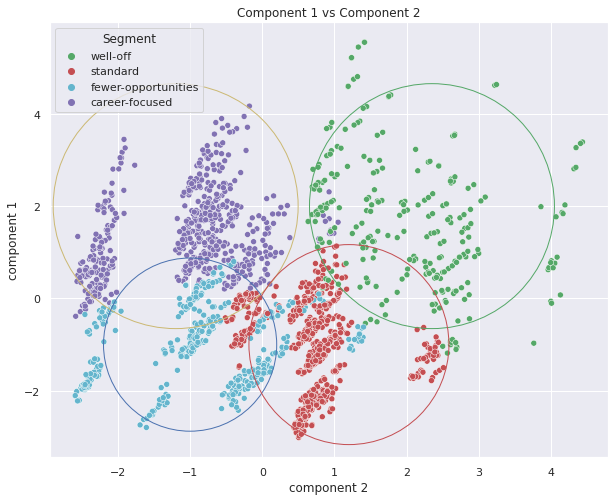

In [220]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=df_segm_pca['component 2'],
    y=df_segm_pca['component 1'],
    hue=df_segm_pca['Segment'],
    palette=['g','r','c','m']
)
plt.scatter(2.35, 2 , s=60000, facecolors='none', edgecolors='g' )
plt.scatter(-1.2, 2 , s=60000, facecolors='none', edgecolors='y' )
plt.scatter(-1, -1 , s=30000, facecolors='none', edgecolors='b' )
plt.scatter(1.2, -1 , s=40000, facecolors='none', edgecolors='r' )

plt.title('Component 1 vs Component 2')
plt.show()

As you can see, now the four segments are distinctly identifiable. Though standard and fewer-opportunity have some overlaps, still the overall result is far better than the previous outcome.

### Conclusion

So far, we have divided our customers into four different and clearly identifiable groups. With this, we have completed the “segmentation” part of the STP framework. Since “targeting” mostly involves business decisions on which customer segment to focus on, we’ll jump over to “positioning”

### Positioning

Positioning is a crucial part of marketing strategy, specially when the firm operates in a highly competitive market. We need to understand how consumers perceive the product offering and how it differs from other competitive offerings. Pricing and discounts play a vital role in shaping customer purchase decisions.

- Data Exploration

We’ll be working with a dataset that represents the customer purchase activities of a retail shop. This dataset is linked with the already familiar customer details dataset that we have already worked with

![Picture title](image-20220927-101829.png)

![Picture title](image-20220927-102733.png)

In [221]:
df_purchase=pd.read_csv('purchase_data.csv')
df_purchase = df_purchase.drop(columns=['Last_Inc_Brand', 'Last_Inc_Quantity'])

df_purchase['Segment'] = df_purchase['Segment'].replace({0: 'standard',1:'career-focused',2: 'fewer-opportunities',3: 'well-off'
})

df_purchase['Mean_Price'] = (df_purchase['Price_1'] + df_purchase['Price_2'] + df_purchase['Price_3'] + df_purchase['Price_4'] + df_purchase['Price_5']) / 5
df_purchase['Has_Promotion'] = (df_purchase['Promotion_1'] + df_purchase['Promotion_2'] + df_purchase['Promotion_3'] + df_purchase['Promotion_4'] + df_purchase['Promotion_5'])

def get_active_price(record):
    if record['Brand'] == 1: return record['Price_1']
    if record['Brand'] == 2: return record['Price_2']
    if record['Brand'] == 3: return record['Price_3']
    if record['Brand'] == 4: return record['Price_4']
    if record['Brand'] == 5: return record['Price_5']
    return 0

df_purchase['Action_Price'] = df_purchase.apply(lambda x: get_active_price(x), axis=1)

df_purchase.head()

,ID,Day,Incidence,Brand,Quantity,Price_1,Price_2,Price_3,Price_4,Price_5,Promotion_1,Promotion_2,Promotion_3,Promotion_4,Promotion_5,Segment,Mean_Price,Has_Promotion,Action_Price
0,200000001,1,0,0,0,1.59,1.87,2.01,2.09,2.66,0,1,0,0,0,fewer-opportunities,2.044,1,0.0
1,200000001,11,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,fewer-opportunities,2.028,0,0.0
2,200000001,12,0,0,0,1.51,1.89,1.99,2.09,2.66,0,0,0,0,0,fewer-opportunities,2.028,0,0.0
3,200000001,16,0,0,0,1.52,1.89,1.98,2.09,2.66,0,0,0,0,0,fewer-opportunities,2.028,0,0.0
4,200000001,18,0,0,0,1.52,1.89,1.99,2.09,2.66,0,0,0,0,0,fewer-opportunities,2.030,0,0.0


In [222]:
df_purchase['Segment']

0        fewer-opportunities
1        fewer-opportunities
2        fewer-opportunities
3        fewer-opportunities
4        fewer-opportunities
                ...         
58688    fewer-opportunities
58689    fewer-opportunities
58690    fewer-opportunities
58691    fewer-opportunities
58692    fewer-opportunities
Name: Segment, Length: 58693, dtype: object

Let’s start our data exploration with the number of unique customers per segment. We see that the biggest segment is the “fewer-opportunity” segment (38%), and other segments are almost of equal weight (around 20%). That is a well-balanced dataset we are working with.

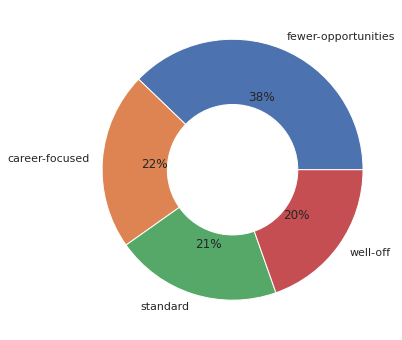

In [223]:
df_segment = df_purchase[['ID', 'Segment']].drop_duplicates()
segments = df_segment['Segment'].value_counts()

segments.plot.pie(figsize=(6, 6), autopct='%1.0f%%', label='') # startangle=0
p = plt.gcf()
p.gca().add_artist(plt.Circle((0,0), 0.5, color='white'))

plt.show()

Each segment also looks quite balanced in terms of the number of actual purchase records (Incidence = 1).

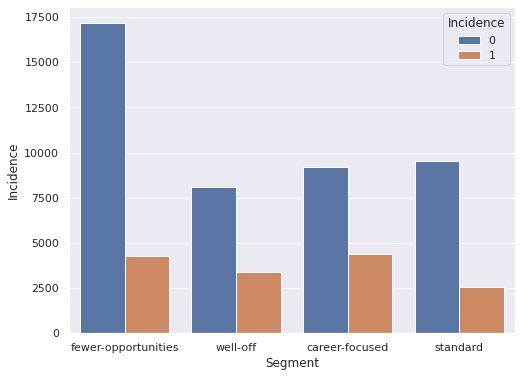

In [224]:
plt.figure(figsize=(8, 6))
s = sns.countplot(data=df_purchase, x='Segment', hue='Incidence')
plt.xlabel('Segment')
plt.ylabel('Incidence')
plt.show()

Now, when we look at the average price of each segment, they look very similar. All of them are at around the 2.0 level. But as we narrow our focus and look at the actual purchase price, we can see the “well-off” segment has a higher average price point (2.2), and the “career-focused” customers are at an even higher price point (2.65).

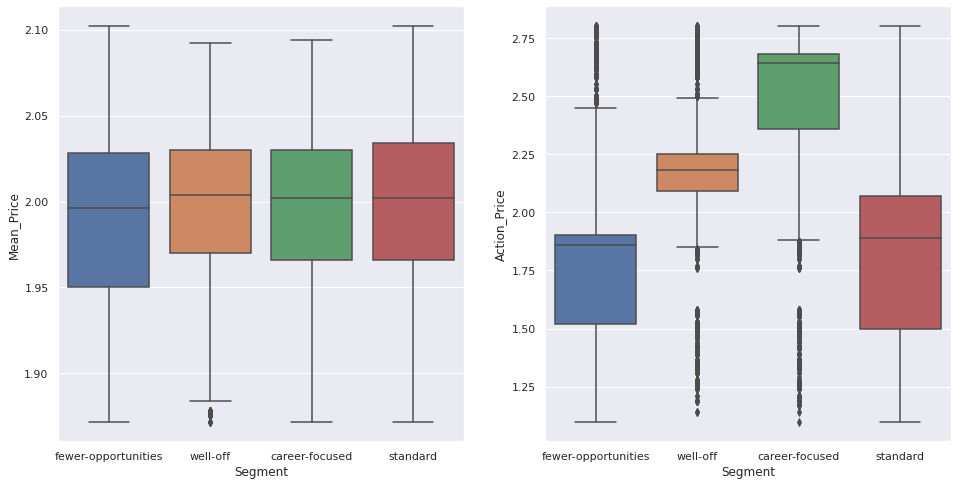

In [225]:
df_segment_incidence = df_purchase[df_purchase['Incidence'] == 1].copy()

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

sns.boxplot(x='Segment', y='Mean_Price', data=df_segment_incidence, ax=axs[0])
sns.boxplot(x='Segment', y='Action_Price', data=df_segment_incidence, ax=axs[1])

plt.show()

### Logistic Regression Model

In [226]:
X = pd.DataFrame()
X['Mean_Price'] = df_purchase['Mean_Price']
y = df_purchase['Incidence']

lr = LogisticRegression(solver='sag')
lr.fit(X, y)

print(lr.coef_)

[[-2.34885871]]


from the model coefficient, it’s evident that there is an inverse relationship between average price and a purchase event. If the average price decreases, the purchase probability will increase.

We see that the price of candy (among all brands) ranges from 1.1 to 2.8. So, keeping some buffer, let’s take the price range from 0.5 to 3.5, increasing 0.01 at a time, and check how the probability of the purchase event changes.

In [227]:
#df_purchase=pd.read_csv('purchase_data.csv')
df_purchase[['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()


,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [228]:
price_range = np.arange(0.5, 3.5, 0.01)
df_price_range = pd.DataFrame({'Mean_Price': price_range})

In [229]:
y_proba = lr.predict_proba(df_price_range)
purchase_proba = y_proba[:][:, 1]

df_purchase_proba = pd.DataFrame({'Purchase_Proba': purchase_proba})
df_price_proba = pd.concat([df_price_range, df_purchase_proba], axis=1)
# df_price_proba.head(50)

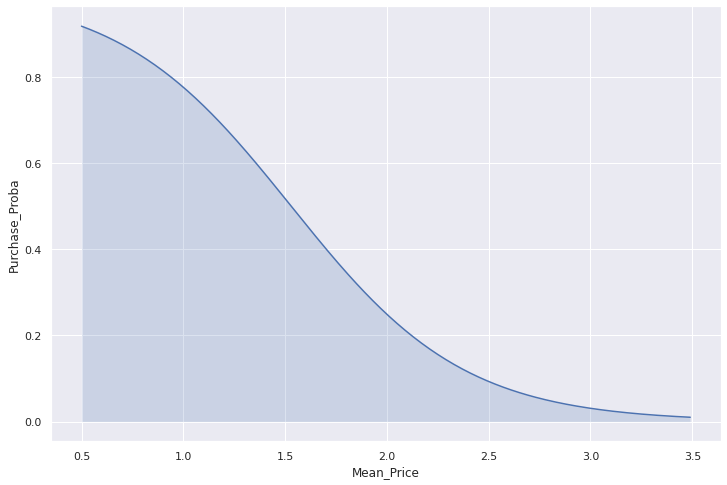

In [230]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(data=df_price_proba, x='Mean_Price', y='Purchase_Proba', ax=ax)
ax.fill_between(data=df_price_proba, x='Mean_Price', y1='Purchase_Proba', alpha=0.2)

plt.show()

### Conclusion

As expected, we observe that as the mean price increases, the chance of purchase decreases.

We shall continue our experiment of price elasticity prediction and learn how much we can increase the price without breaking the demand.

### Predicting Price Elasticity of Demand

In [231]:
pe = lr.coef_[:, 0] * price_range * (1 - purchase_proba)

df_pe = pd.DataFrame({'Mean_Price_Elasticity': pe})
df_price_elasticity = pd.concat([df_price_proba, df_pe], axis=1)
df_price_elasticity

,Mean_Price,Purchase_Proba,Mean_Price_Elasticity
0,0.50,0.918361,-0.095879
1,0.51,0.916582,-0.099927
2,0.52,0.914769,-0.104102
3,0.53,0.912920,-0.108406
4,0.54,0.911034,-0.112843
...,...,...,...
295,3.45,0.010891,-8.015305
296,3.46,0.010641,-8.040571
297,3.47,0.010397,-8.065802
298,3.48,0.010158,-8.090999


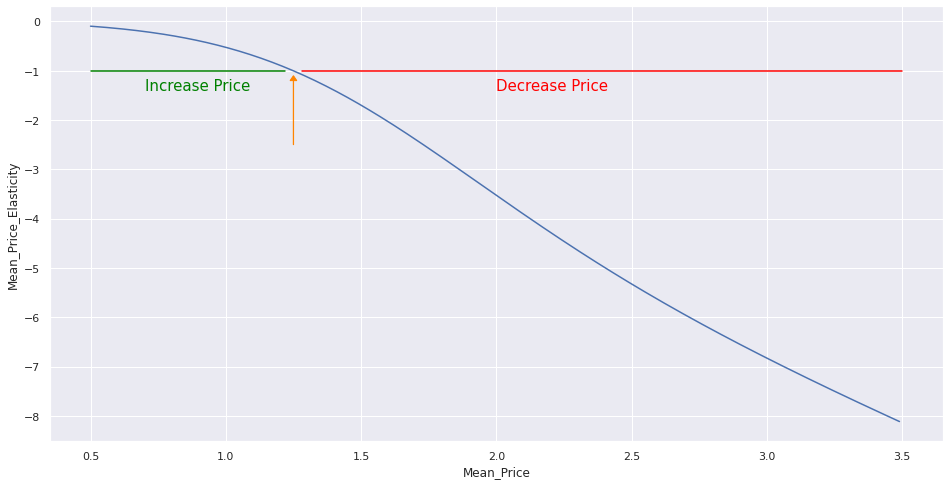

In [232]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df_price_elasticity, x='Mean_Price', y='Mean_Price_Elasticity', ax=ax)

plt.arrow(1.25, -2.5, 0, 1.3, head_width=0.025, head_length=0.1, color='#FF8400')

plt.plot([0.5, 1.22], [-1, -1], color='green')
plt.annotate("Increase Price", xy=(0.7, -1.4), color='green', fontsize=15)
plt.plot([1.28, 3.5], [-1, -1], color='red')
plt.annotate("Decrease Price", xy=(2.0, -1.4), color='red', fontsize=15)

plt.show()

### Compare Price Elasticity by Segment

In [233]:
df_purchase['Incidence'].value_counts()

0    44055
1    14638
Name: Incidence, dtype: int64

In [234]:
df_purchase['Segment']

0        fewer-opportunities
1        fewer-opportunities
2        fewer-opportunities
3        fewer-opportunities
4        fewer-opportunities
                ...         
58688    fewer-opportunities
58689    fewer-opportunities
58690    fewer-opportunities
58691    fewer-opportunities
58692    fewer-opportunities
Name: Segment, Length: 58693, dtype: object

In [235]:
df_purchase['Mean_Price']=(df_purchase['Price_1']+df_purchase['Price_2']+df_purchase['Price_3']+df_purchase['Price_4']+df_purchase['Price_5'])/5

In [236]:
seg_list = ['standard', 'career-focused', 'fewer-opportunities', 'well-off']

for seg in seg_list:
    df_data = df_purchase.copy()
    df_data = df_data[df_data['Segment'] == seg]

    X = pd.DataFrame()
    X['Mean_Price'] = df_data['Mean_Price']
    y = df_data['Incidence']

    lr = LogisticRegression(solver='sag')
    lr.fit(X,y)

    y_proba = lr.predict_proba(df_price_range)
    purchase_proba = y_proba[:][:, 1]
    pe = lr.coef_[:, 0] * price_range * (1 - purchase_proba)
    
    df_price_elasticity[seg + '_Price_Elasticity'] = pe

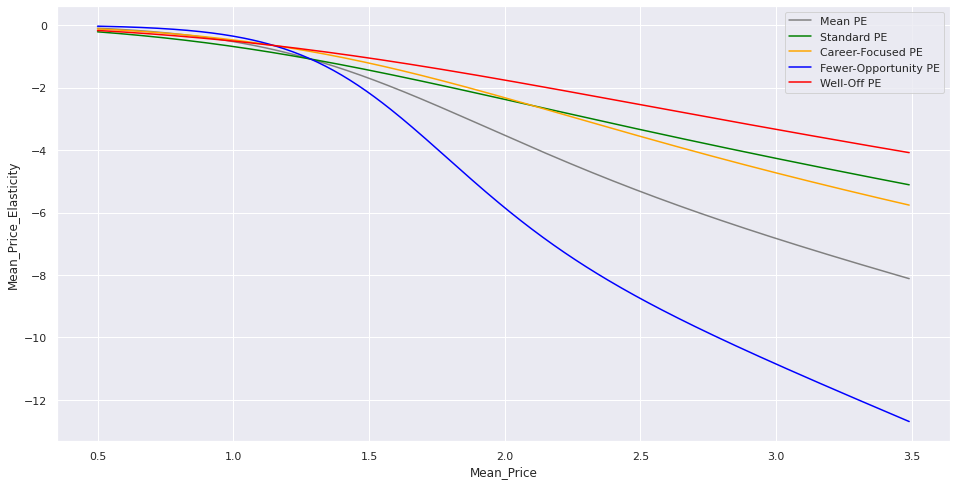

In [237]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=df_price_elasticity, x='Mean_Price', y='Mean_Price_Elasticity', ax=ax, color='gray', label='Mean PE')
sns.lineplot(data=df_price_elasticity, x='Mean_Price', y='standard_Price_Elasticity', ax=ax, color='green', label='Standard PE')
sns.lineplot(data=df_price_elasticity, x='Mean_Price', y='career-focused_Price_Elasticity', ax=ax, color='orange', label='Career-Focused PE')
sns.lineplot(data=df_price_elasticity, x='Mean_Price', y='fewer-opportunities_Price_Elasticity', ax=ax, color='blue', label='Fewer-Opportunity PE')
sns.lineplot(data=df_price_elasticity, x='Mean_Price', y='well-off_Price_Elasticity', ax=ax, color='red', label='Well-Off PE')

plt.show()

In [238]:
df_price_elasticity

,Mean_Price,Purchase_Proba,Mean_Price_Elasticity,standard_Price_Elasticity,career-focused_Price_Elasticity,fewer-opportunities_Price_Elasticity,well-off_Price_Elasticity
0,0.50,0.918361,-0.095879,-0.211093,-0.119055,-0.030930,-0.168010
1,0.51,0.916582,-0.099927,-0.217656,-0.123237,-0.032698,-0.172933
2,0.52,0.914769,-0.104102,-0.224326,-0.127512,-0.034552,-0.177927
3,0.53,0.912920,-0.108406,-0.231105,-0.131882,-0.036498,-0.182992
4,0.54,0.911034,-0.112843,-0.237993,-0.136348,-0.038538,-0.188128
...,...,...,...,...,...,...,...
295,3.45,0.010891,-8.015305,-5.043263,-5.680253,-12.544913,-4.021434
296,3.46,0.010641,-8.040571,-5.060098,-5.700409,-12.581838,-4.036300
297,3.47,0.010397,-8.065802,-5.076915,-5.720529,-12.618746,-4.051150
298,3.48,0.010158,-8.090999,-5.093714,-5.740613,-12.655638,-4.065983


We see in the graph (also in the dataframe) that the average inelastic price of well-off and career-focused groups is about 14 percent higher than the fewer-opportunity and standard segment. This allows us to increase the price for those earlier segments as long as the PED remains inelastic.

Another deduction we can make is that the steepness of lines varies on the right side of the graph (beyond price point 1.5). It indicates the different elasticity levels per segment and tells how the demand would act with the price increase. We have to carefully tune the price to maintain a healthy level of demand whilst the PED is elastic. Seems like the fewer-opportunity group is more sensitive to the price than other segments.